# Time Delayed Neural Network (TDNN) implemented in PyTorch over NARMA10 task

NARMA10 is a benchmark task for testing the ability of a model to learn long-term dependencies. It is a synthetic time series dataset that is generated by a nonlinear autoregressive moving average model of order 10. The task is to predict the next value of the time series given the previous 10 values. The dataset is generated by the following equation:

$$
y(t) = 0.3y(t-1) + 0.05y(t-1)y(t-10) + 1.5x(t-1)x(t-10) + 0.1
$$

where $y(t)$ is the output at time $t$ and $x(t)$ is the input at time $t$. The input $x(t)$ is a random number between 0 and 0.5. The output $y(t)$ is a function of the previous 10 values of $x(t)$ and $y(t)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# import data from NARMA10 csv as a single column
data = pd.read_csv('NARMA10.csv', header=None)
data_MG17 = pd.read_csv('MG17.csv', header=None)

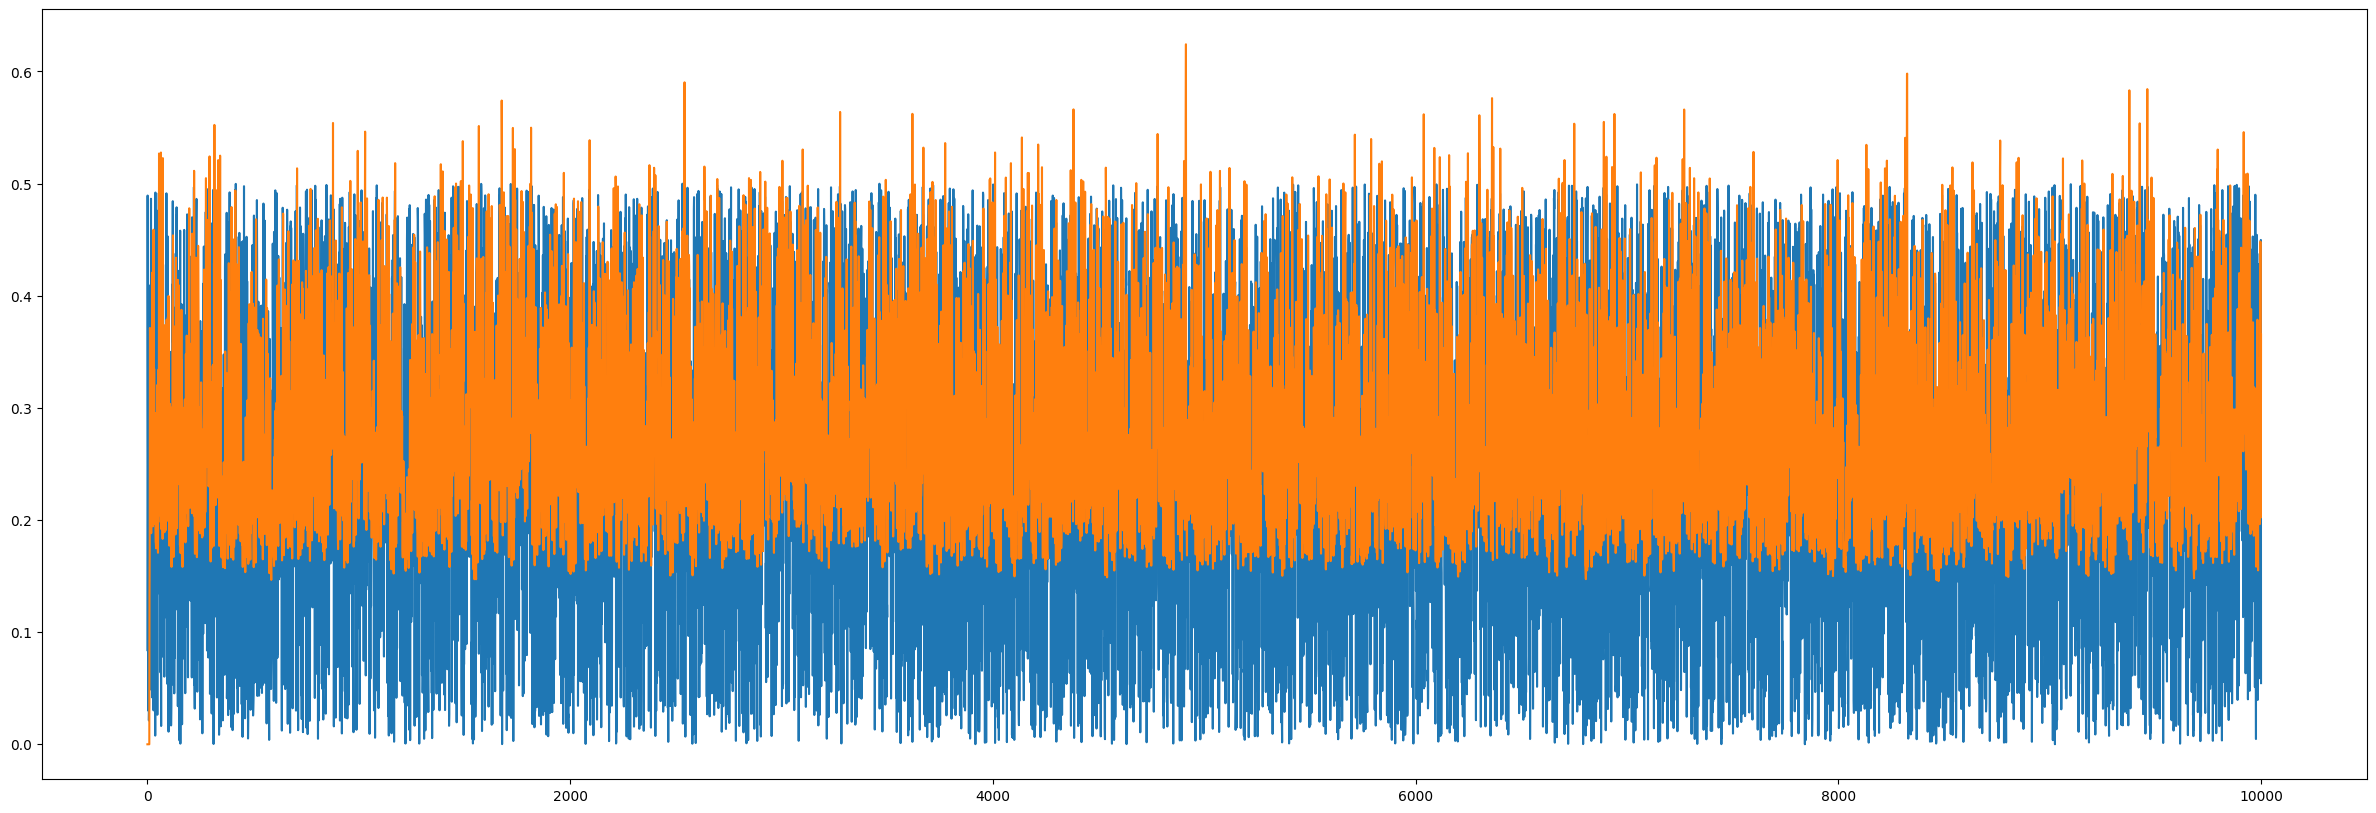

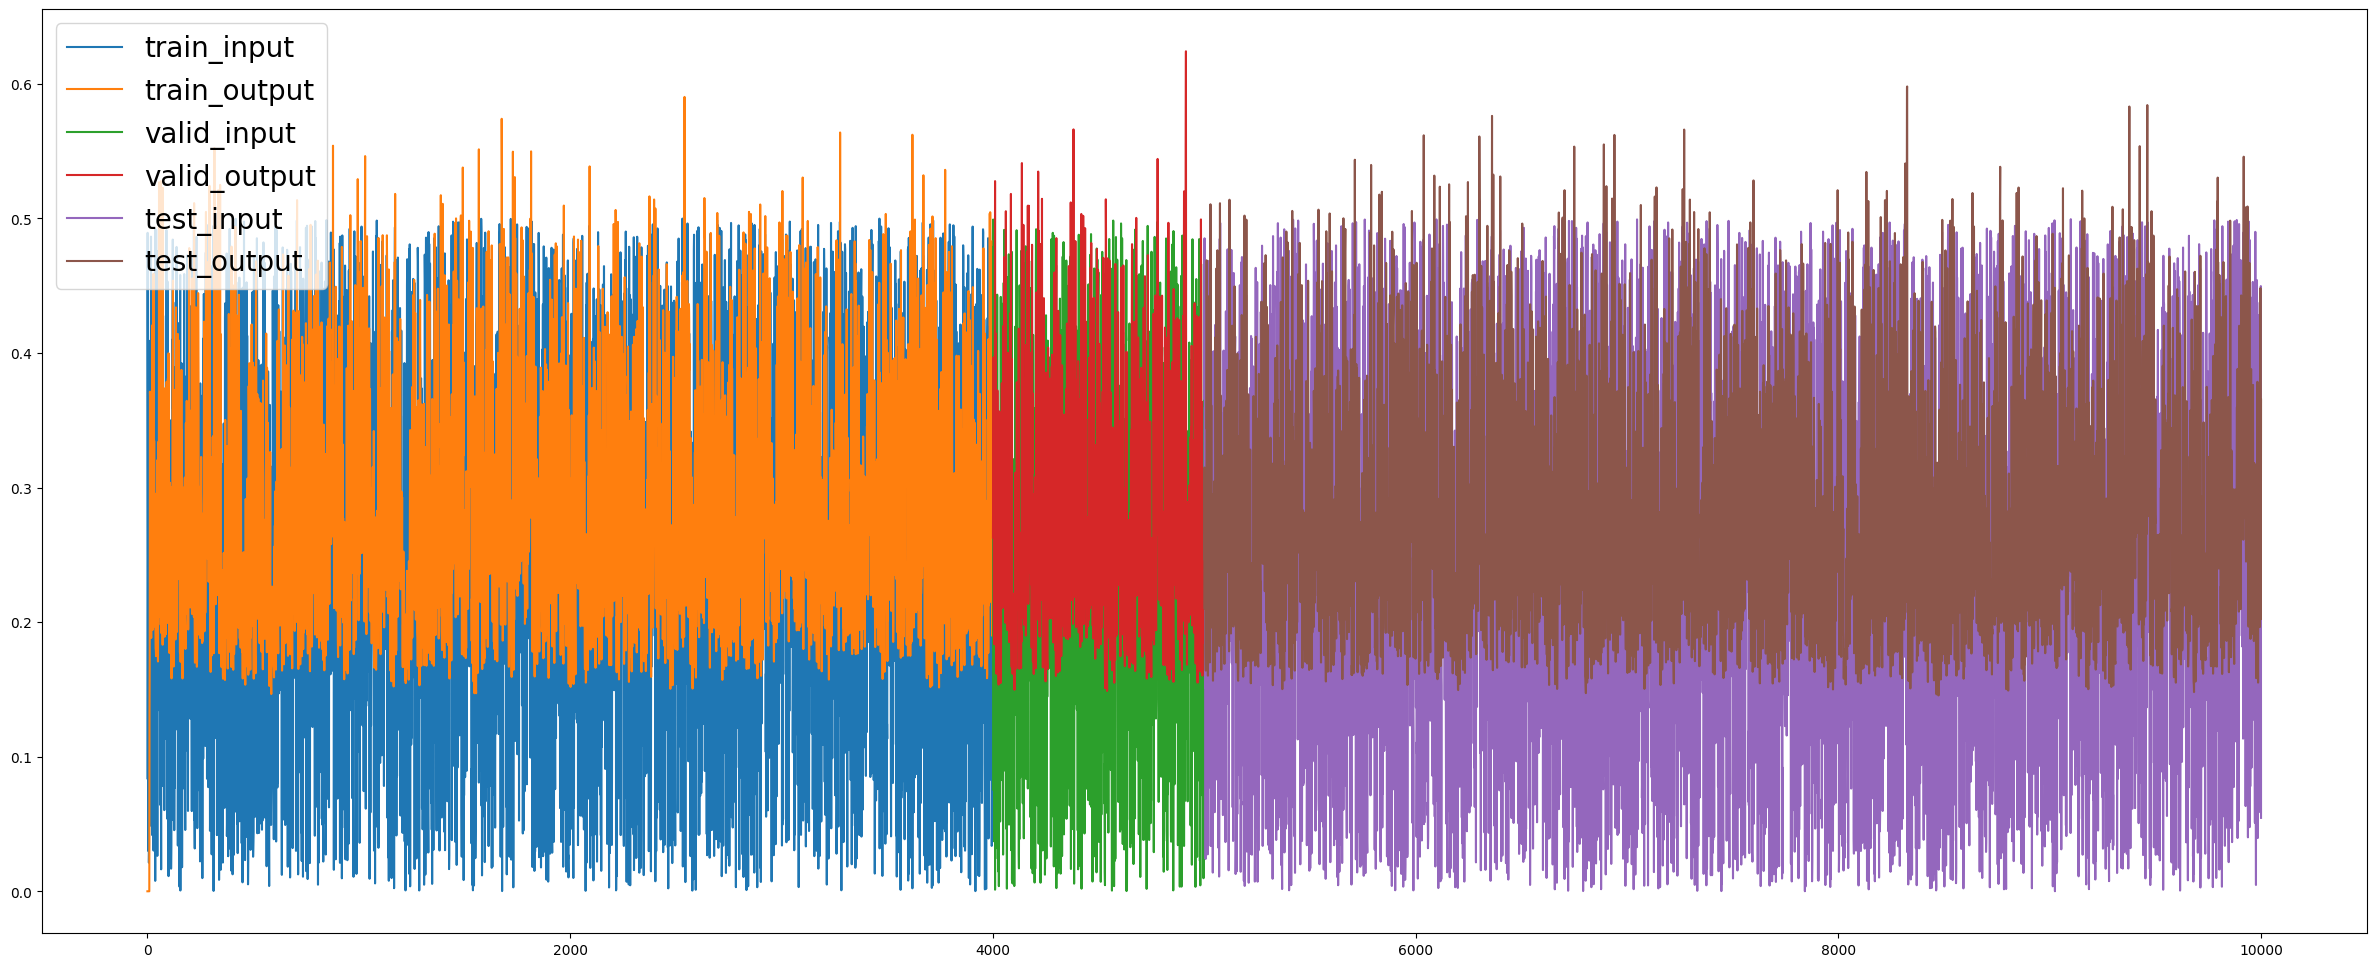

In [3]:
# plot the data in time series format
data.shape

# First row is the input signal x
input_data = data.iloc[0]  
# Second row is the application of y(t) to our x data
output_data = data.iloc[1]

# make larger x-axis
plt.figure(figsize=(30,10))
plt.plot(input_data)

plt.plot(output_data)


# Suggestion on spits: 5000 in developement (4k train, 1k valid) and 5000 in test
# Use the hidden state of the RNN for the valid after train. For the test one can retrain the model with the full dataset 
# and then use the last hidden state for the test. Or use a transient period (at least 10 steps since the NARMA10 
# based on last 10 steps)

# Split the data into train, valid and test
train_input = input_data[:4000]
train_output = output_data[:4000]

valid_input = input_data[4000:5000]
valid_output = output_data[4000:5000]

test_input = input_data[5000:]
test_output = output_data[5000:]

# make copy of the train input and valid to use in the other model
train_input_copy = train_input.copy()
valid_input_copy = valid_input.copy()
test_input_copy = test_input.copy()
train_output_copy = train_output.copy()
valid_output_copy = valid_output.copy()
test_output_copy = test_output.copy()


# plot the data in time series format
plt.figure(figsize=(30,12))
plt.plot(train_input)
plt.plot(train_output)
plt.plot(valid_input)
plt.plot(valid_output)
plt.plot(test_input)
plt.plot(test_output)

# legend
plt.legend(['train_input', 'train_output', 'valid_input', 'valid_output', 'test_input', 'test_output'], loc='upper left', fontsize=20)

In [4]:
# divide in train, valid and test the MG17 data, is a single time series of 10000 steps, take 5000 train, 1000 valid and 4000 test
data_MG17.shape
# Index of the timestep is on the columns, so we take first 5000 columns for train, next 1000 for valid and last 4000 for test
train_MG17 = data_MG17.iloc[:, :5000]
valid_MG17 = data_MG17.iloc[:, 5000:6000]
test_MG17 = data_MG17.iloc[:, 6000:]



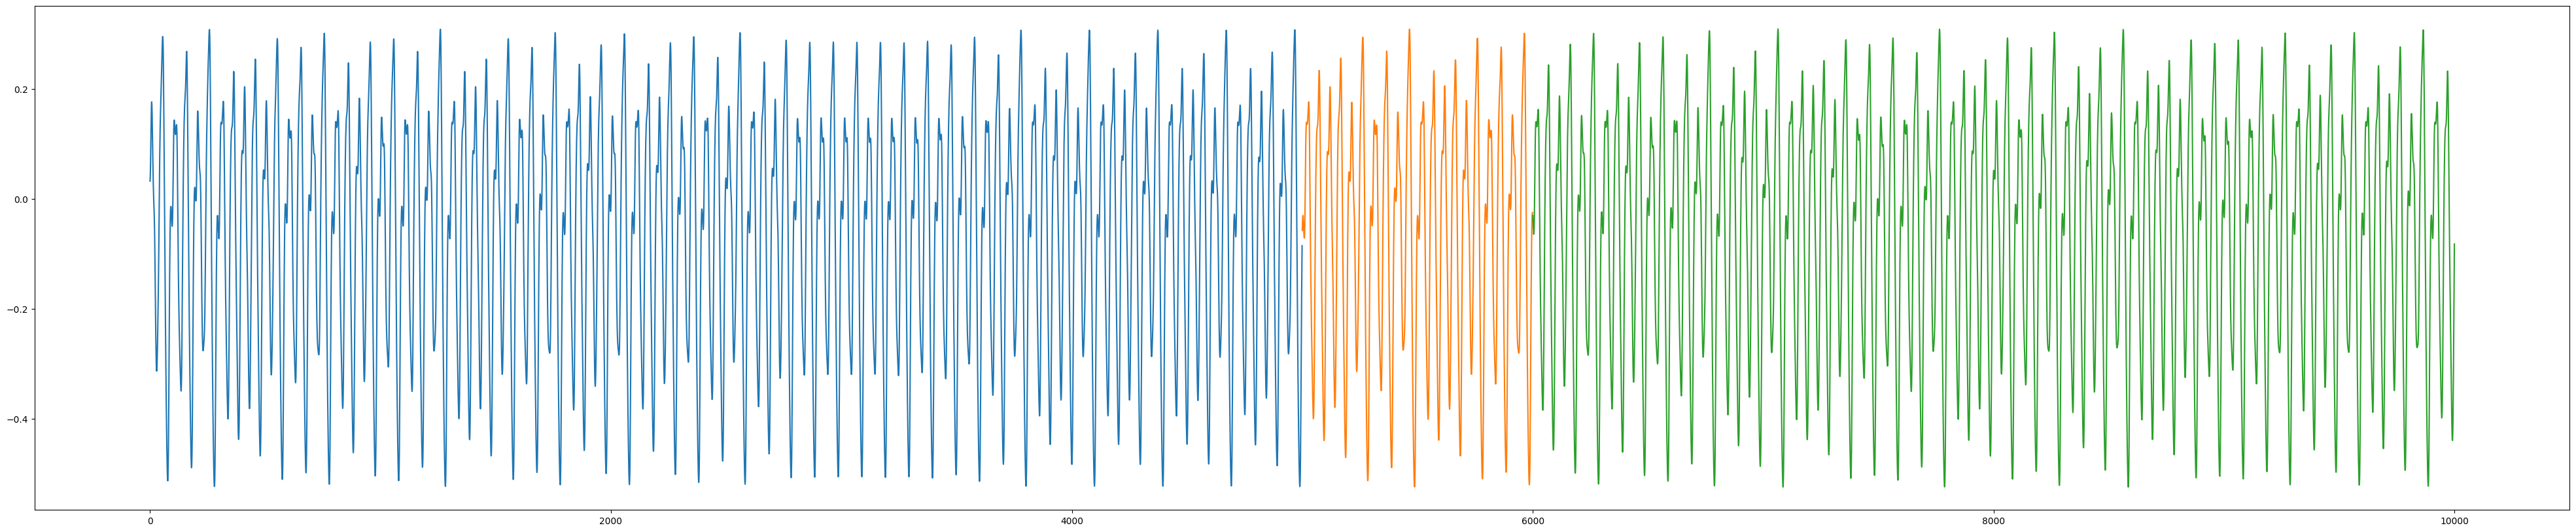

In [5]:
# for each column plot in time series format the data, train, valid and test
plt.figure(figsize=(50,10))
for i in range(0, 1):
    plt.plot(train_MG17.iloc[i])
    plt.plot(valid_MG17.iloc[i])
    plt.plot(test_MG17.iloc[i])

# Best params
- 1 Layer, 50 hidden, 3 dilation, 1 kernel size, 1 stride, 1 padding, 0 dropout, 0 bias

In [6]:
# Some advice on TDNN can use 1D convolutions with kernel size 1.
from tqdm import tqdm
from torch import nn
from TimeDelayNeuralNetwork import *

USE_CUDA = False

if USE_CUDA:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
else:
    device = 'cpu'


KERNEL_SIZE = 39
PADDING = (KERNEL_SIZE - 1)//2


tdnn = TimeDelayNeuralNetwork(
    input_size=1,
    hidden_size=150,
    output_size=1,
    kernel_size=KERNEL_SIZE,
    dilation=1,
    pool_size=1,
    pool_stride=1,   
    padding=PADDING
)

tdnn.to(device)

print("Current device being used: ", device)

error = nn.MSELoss()

# SGD Optimizer 
lr = 0.015
optimizer = torch.optim.SGD(tdnn.parameters(), lr=lr, momentum=0.3, weight_decay=0.0001)

loss_list = []
valid_loss = []
iteration_list = []
acccuracy_list = []
count = 0

num_epochs = 100

#window_size = 100

# split the data in chunks of window_size, 1,

# Training loop
for i in tqdm(range(num_epochs)):
#    for j in range(window_size, len(train_input)):
    optimizer.zero_grad()
    
    # take current window
    #window_input = train_input[j-window_size:j]
    # take as window_input the whole train_input
    window_input = train_input
    
    # to tensor
    window_input = torch.tensor(window_input.values).float()
    window_input = window_input.unsqueeze(1).unsqueeze(2)


    # check if train_output is a tensor
    if not torch.is_tensor(train_output):
        train_output = torch.tensor(train_output).float()
        target = train_output        
    
    #!TODO current 3D shaped passed is (window_size, 1, 1) we have windows_size (timesteps), batch_size, feature
    
    # forward pass
    output = tdnn(window_input)
    
    # calculate the loss
    loss = error(output, target)
    
    # backwar pass
    loss.backward()
    optimizer.step()
    
    count += 1

    # store the loss
    loss_list.append(loss.item())
    iteration_list.append(count)
    
    # validation
    # go in eval mode
    #tdnn.eval()
    # print("Validating")
    if count % 1 == 0:
        with torch.no_grad():
            
            if device == 'cuda':
                valid_input_tensor = torch.tensor(valid_input.values).float().unsqueeze(1).unsqueeze(2).cuda()
                valid_output_tensor = torch.tensor(valid_output.values).float().cuda()
            else:
                valid_input_tensor = torch.tensor(valid_input.values).float().unsqueeze(1).unsqueeze(2)
                valid_output_tensor = torch.tensor(valid_output.values).float()
            
            valid_loss.append(error(tdnn(valid_input_tensor), valid_output_tensor))
        
        print(f"Epoch: {i}, Loss: {loss.item()}, Valid Loss: {valid_loss[-1]}")
            
acccuracy_list=valid_loss

Current device being used:  cpu


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\cenzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([4000])) that is different to the input size (torch.Size([4000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\cenzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  3%|▎         | 3/100 [00:01<00:38,  2.52it/s]

Epoch: 0, Loss: 0.07785854488611221, Valid Loss: 0.07007339596748352
Epoch: 1, Loss: 0.07035200297832489, Valid Loss: 0.06072525680065155
Epoch: 2, Loss: 0.06132608652114868, Valid Loss: 0.05216620862483978
Epoch: 3, Loss: 0.05327853187918663, Valid Loss: 0.045082587748765945


  7%|▋         | 7/100 [00:01<00:14,  6.44it/s]

Epoch: 4, Loss: 0.04639808088541031, Valid Loss: 0.039253201335668564
Epoch: 5, Loss: 0.040143415331840515, Valid Loss: 0.03430869057774544
Epoch: 6, Loss: 0.03516156226396561, Valid Loss: 0.030502386391162872
Epoch: 7, Loss: 0.031217405572533607, Valid Loss: 0.027156325057148933


 11%|█         | 11/100 [00:01<00:08, 10.31it/s]

Epoch: 8, Loss: 0.027629369869828224, Valid Loss: 0.0246334969997406
Epoch: 9, Loss: 0.02458568476140499, Valid Loss: 0.021546008065342903
Epoch: 10, Loss: 0.022363491356372833, Valid Loss: 0.019806472584605217
Epoch: 11, Loss: 0.019993329420685768, Valid Loss: 0.018632445484399796


 15%|█▌        | 15/100 [00:02<00:06, 13.03it/s]

Epoch: 12, Loss: 0.018386421725153923, Valid Loss: 0.016840118914842606
Epoch: 13, Loss: 0.016730695962905884, Valid Loss: 0.01555122435092926
Epoch: 14, Loss: 0.015843303874135017, Valid Loss: 0.014510092325508595
Epoch: 15, Loss: 0.015046441927552223, Valid Loss: 0.013719852082431316


 19%|█▉        | 19/100 [00:02<00:05, 14.45it/s]

Epoch: 16, Loss: 0.013931340537965298, Valid Loss: 0.012645474635064602
Epoch: 17, Loss: 0.013157926499843597, Valid Loss: 0.012410440482199192
Epoch: 18, Loss: 0.012579620815813541, Valid Loss: 0.011767868883907795
Epoch: 19, Loss: 0.011964017525315285, Valid Loss: 0.011433112435042858


 23%|██▎       | 23/100 [00:02<00:06, 12.44it/s]

Epoch: 20, Loss: 0.01172252930700779, Valid Loss: 0.011237522587180138
Epoch: 21, Loss: 0.011267811059951782, Valid Loss: 0.010889315977692604
Epoch: 22, Loss: 0.011064046993851662, Valid Loss: 0.010631382465362549
Epoch: 23, Loss: 0.010771517641842365, Valid Loss: 0.010262688621878624


 27%|██▋       | 27/100 [00:03<00:05, 14.26it/s]

Epoch: 24, Loss: 0.010549363680183887, Valid Loss: 0.01042917650192976
Epoch: 25, Loss: 0.010334428399801254, Valid Loss: 0.010031091049313545
Epoch: 26, Loss: 0.010269719175994396, Valid Loss: 0.01017837692052126
Epoch: 27, Loss: 0.010127957910299301, Valid Loss: 0.010053710080683231


 31%|███       | 31/100 [00:03<00:04, 14.66it/s]

Epoch: 28, Loss: 0.009966735728085041, Valid Loss: 0.009831815026700497
Epoch: 29, Loss: 0.009960834868252277, Valid Loss: 0.009750772267580032
Epoch: 30, Loss: 0.009815244935452938, Valid Loss: 0.00960066169500351
Epoch: 31, Loss: 0.009814937599003315, Valid Loss: 0.009634249843657017


 35%|███▌      | 35/100 [00:03<00:04, 15.51it/s]

Epoch: 32, Loss: 0.009702038951218128, Valid Loss: 0.009586234577000141
Epoch: 33, Loss: 0.009589004330337048, Valid Loss: 0.009403065778315067
Epoch: 34, Loss: 0.009702031500637531, Valid Loss: 0.009384837001562119
Epoch: 35, Loss: 0.009560327045619488, Valid Loss: 0.009484347887337208


 39%|███▉      | 39/100 [00:03<00:04, 15.11it/s]

Epoch: 36, Loss: 0.009602752514183521, Valid Loss: 0.009351484477519989
Epoch: 37, Loss: 0.009504640474915504, Valid Loss: 0.009399673901498318
Epoch: 38, Loss: 0.009422272443771362, Valid Loss: 0.009507384151220322


 41%|████      | 41/100 [00:04<00:04, 13.88it/s]

Epoch: 39, Loss: 0.009457970969378948, Valid Loss: 0.00937631819397211
Epoch: 40, Loss: 0.009488583542406559, Valid Loss: 0.009448573924601078
Epoch: 41, Loss: 0.009475803934037685, Valid Loss: 0.009414509870111942


 45%|████▌     | 45/100 [00:04<00:03, 15.13it/s]

Epoch: 42, Loss: 0.009434922598302364, Valid Loss: 0.009361108765006065
Epoch: 43, Loss: 0.009434806182980537, Valid Loss: 0.009470835328102112
Epoch: 44, Loss: 0.00939130038022995, Valid Loss: 0.009299133904278278
Epoch: 45, Loss: 0.009432719089090824, Valid Loss: 0.009486949071288109


 49%|████▉     | 49/100 [00:04<00:03, 16.62it/s]

Epoch: 46, Loss: 0.009421301074326038, Valid Loss: 0.009298195131123066
Epoch: 47, Loss: 0.009365045465528965, Valid Loss: 0.00928390584886074
Epoch: 48, Loss: 0.009409952908754349, Valid Loss: 0.00927664153277874
Epoch: 49, Loss: 0.009432005695998669, Valid Loss: 0.009426286444067955


 53%|█████▎    | 53/100 [00:04<00:02, 16.93it/s]

Epoch: 50, Loss: 0.009440585970878601, Valid Loss: 0.00925069022923708
Epoch: 51, Loss: 0.009437445551156998, Valid Loss: 0.009397397749125957
Epoch: 52, Loss: 0.009420440532267094, Valid Loss: 0.00947603490203619
Epoch: 53, Loss: 0.009338204748928547, Valid Loss: 0.009379571303725243


 57%|█████▋    | 57/100 [00:04<00:02, 16.48it/s]

Epoch: 54, Loss: 0.009396689012646675, Valid Loss: 0.009387601166963577
Epoch: 55, Loss: 0.009352009743452072, Valid Loss: 0.00929310079663992
Epoch: 56, Loss: 0.009324931539595127, Valid Loss: 0.009385785087943077
Epoch: 57, Loss: 0.009321868419647217, Valid Loss: 0.009155003353953362


 61%|██████    | 61/100 [00:05<00:02, 17.30it/s]

Epoch: 58, Loss: 0.009363516233861446, Valid Loss: 0.009438841603696346
Epoch: 59, Loss: 0.009300116449594498, Valid Loss: 0.0093424953520298
Epoch: 60, Loss: 0.009337101131677628, Valid Loss: 0.009342880919575691


 63%|██████▎   | 63/100 [00:05<00:02, 13.76it/s]

Epoch: 61, Loss: 0.009352048859000206, Valid Loss: 0.009273357689380646
Epoch: 62, Loss: 0.009283151477575302, Valid Loss: 0.009389174170792103
Epoch: 63, Loss: 0.009306365624070168, Valid Loss: 0.00932012964040041
Epoch: 64, Loss: 0.00931821670383215, Valid Loss: 0.009238310158252716


 67%|██████▋   | 67/100 [00:05<00:02, 15.01it/s]

Epoch: 65, Loss: 0.009276848286390305, Valid Loss: 0.009346275590360165
Epoch: 66, Loss: 0.009386121295392513, Valid Loss: 0.00932090263813734
Epoch: 67, Loss: 0.009334203787147999, Valid Loss: 0.009232372976839542
Epoch: 68, Loss: 0.009317871183156967, Valid Loss: 0.00932586845010519


 71%|███████   | 71/100 [00:05<00:01, 15.76it/s]

Epoch: 69, Loss: 0.009311697445809841, Valid Loss: 0.009174973703920841
Epoch: 70, Loss: 0.009347368963062763, Valid Loss: 0.009436667896807194
Epoch: 71, Loss: 0.009344195015728474, Valid Loss: 0.009311646223068237


 75%|███████▌  | 75/100 [00:06<00:01, 14.76it/s]

Epoch: 72, Loss: 0.009335682727396488, Valid Loss: 0.009279931895434856
Epoch: 73, Loss: 0.009298424236476421, Valid Loss: 0.009323248639702797
Epoch: 74, Loss: 0.009271050803363323, Valid Loss: 0.009313534945249557
Epoch: 75, Loss: 0.009222039952874184, Valid Loss: 0.009283121675252914


 79%|███████▉  | 79/100 [00:06<00:01, 14.47it/s]

Epoch: 76, Loss: 0.009281923994421959, Valid Loss: 0.00908722449094057
Epoch: 77, Loss: 0.009289087727665901, Valid Loss: 0.009291336871683598
Epoch: 78, Loss: 0.009259244427084923, Valid Loss: 0.00934473518282175


 83%|████████▎ | 83/100 [00:06<00:01, 15.84it/s]

Epoch: 79, Loss: 0.009329847991466522, Valid Loss: 0.009307635016739368
Epoch: 80, Loss: 0.00931637641042471, Valid Loss: 0.00931541807949543
Epoch: 81, Loss: 0.009289269335567951, Valid Loss: 0.009216954000294209
Epoch: 82, Loss: 0.009277742356061935, Valid Loss: 0.009205030277371407


 85%|████████▌ | 85/100 [00:06<00:00, 16.67it/s]

Epoch: 83, Loss: 0.009239915758371353, Valid Loss: 0.009211231023073196
Epoch: 84, Loss: 0.009227721020579338, Valid Loss: 0.009111767634749413
Epoch: 85, Loss: 0.009279074147343636, Valid Loss: 0.009269777685403824


 89%|████████▉ | 89/100 [00:07<00:00, 14.35it/s]

Epoch: 86, Loss: 0.00918666087090969, Valid Loss: 0.009312835521996021
Epoch: 87, Loss: 0.00924884993582964, Valid Loss: 0.009215508587658405
Epoch: 88, Loss: 0.009247303009033203, Valid Loss: 0.009208089672029018


 91%|█████████ | 91/100 [00:07<00:00, 14.18it/s]

Epoch: 89, Loss: 0.009242142550647259, Valid Loss: 0.009213515557348728
Epoch: 90, Loss: 0.009181201457977295, Valid Loss: 0.009215927682816982
Epoch: 91, Loss: 0.009172119200229645, Valid Loss: 0.009102493524551392
Epoch: 92, Loss: 0.009154587052762508, Valid Loss: 0.009314573369920254


 97%|█████████▋| 97/100 [00:07<00:00, 15.93it/s]

Epoch: 93, Loss: 0.009184716269373894, Valid Loss: 0.009218786843121052
Epoch: 94, Loss: 0.009258988313376904, Valid Loss: 0.009145027957856655
Epoch: 95, Loss: 0.009220187552273273, Valid Loss: 0.009156937710940838
Epoch: 96, Loss: 0.00918169878423214, Valid Loss: 0.009210132993757725


100%|██████████| 100/100 [00:07<00:00, 12.76it/s]

Epoch: 97, Loss: 0.009188894182443619, Valid Loss: 0.009125521406531334
Epoch: 98, Loss: 0.009175436571240425, Valid Loss: 0.009188472293317318
Epoch: 99, Loss: 0.009205853566527367, Valid Loss: 0.009238669648766518


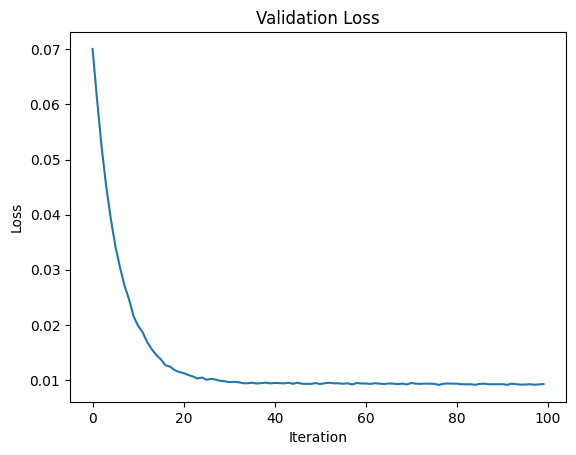

Text(0.5, 1.0, 'Training Loss')

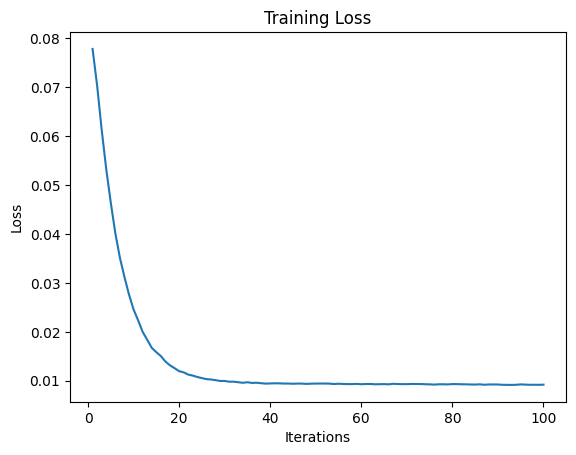

In [7]:
# plot validation loss
plt.plot(acccuracy_list)
plt.title('Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

# Plot the loss and validation loss

plt.plot(iteration_list, loss_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')



# Visualizing the NARMA10 dataset reconstructed by TDNN

In [8]:
# get prediction for training and validation
train_input_tensor = torch.Tensor(train_input.values).unsqueeze(1).unsqueeze(2)
output_train = tdnn(train_input_tensor)

valid_input_tensor = torch.Tensor(valid_input.values).unsqueeze(1).unsqueeze(2)
output_valid = tdnn(valid_input_tensor)

output_train.shape

torch.Size([4000, 1])

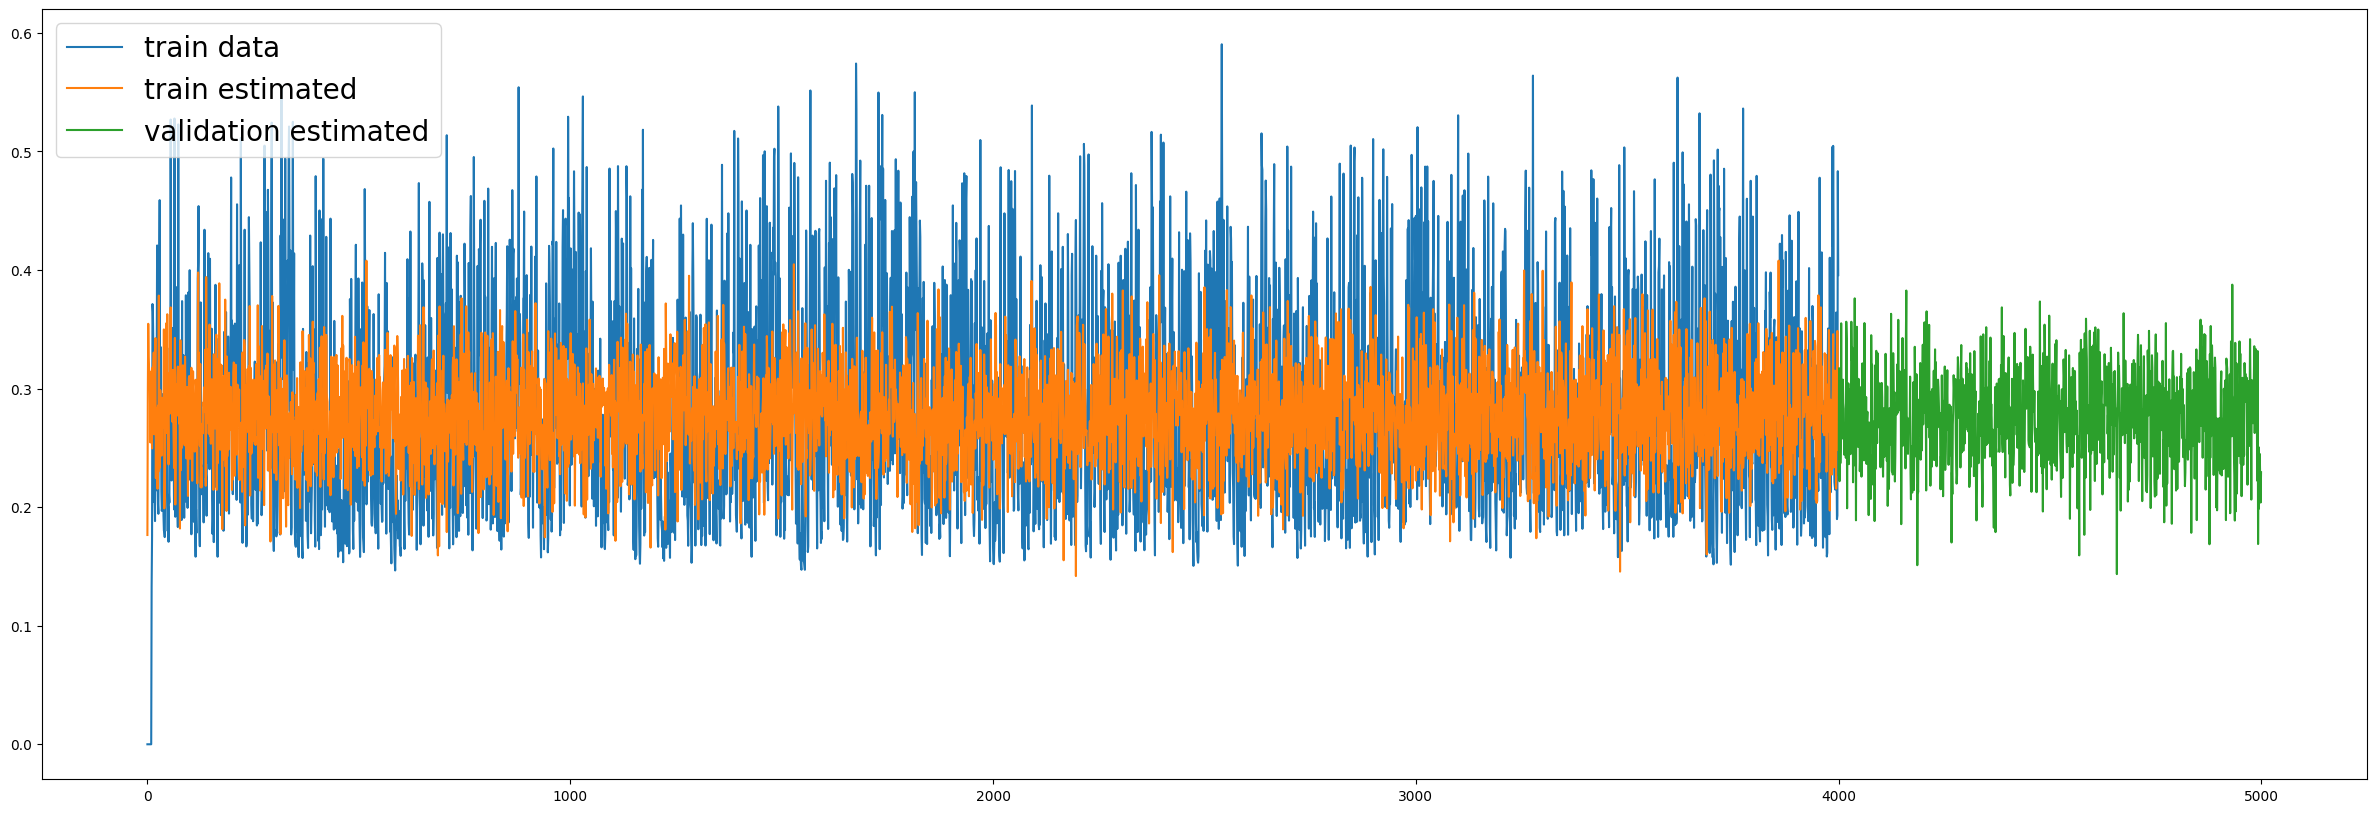

In [9]:

#get prediction for training input
input_train = torch.Tensor(train_input.values).unsqueeze(1).unsqueeze(2)
output_train = tdnn(input_train)
# detach the tensor
output_train = output_train.detach().numpy()
output_valid = output_valid.detach().numpy()
# converrt the tensor in the numpy array time series taking first only the time serie
#output_train = output_train.squeeze(2).detach().numpy()
# take the first element of the tensor
#output_train = output_train[:,1]

# figsize 30,10
plt.figure(figsize=(30,10))
# add ground truth for train output
plt.plot(train_output)
# add estimated output for train output
plt.plot(output_train)
# after 4000 step put the output_valid
plt.plot(np.arange(4000, 5000), output_valid[:,0])

plt.legend(['train data', 'train estimated', 'validation estimated'], loc='upper left', fontsize=20)

#output_train.shape

# Let's try RNN now

In [10]:
from RecurrentNeuralNetwork import *
from tqdm import tqdm

In [11]:
# get the copied data
train_input = train_input_copy
valid_input = valid_input_copy
test_input = test_input_copy

train_output = train_output_copy
valid_output = valid_output_copy
test_output = test_output_copy


In [12]:
rnn = RNN(
    input_size=1,
    hidden_size=100,
    output_size=1,
    num_layers=1
)

optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
loss = nn.MSELoss()

C:\Users\cenzo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [13]:
# Training loop for RNN
num_epochs = 100
batch_size = 128
h_out = None
train_loss = []
valid_loss = []

for epoch in tqdm(range(num_epochs)):
    print(f'Epoch {epoch}')
    for i in range(0, len(train_input), batch_size):
        optimizer.zero_grad()
        
        input_batch = torch.Tensor(train_input[i:i+batch_size].values).unsqueeze(1).unsqueeze(2)
        output_batch = torch.Tensor(train_output[i:i+batch_size].values).unsqueeze(1).unsqueeze(2)
    
        output, h_out = rnn(input_batch, h_out)
        
        h_out = h_out.detach() if h_out is not None else None

        l = loss(output, output_batch)
        
        l.backward()
        optimizer.step()
        

    with torch.no_grad():
        
        valid_input_tensor = torch.Tensor(valid_input.values).unsqueeze(1).unsqueeze(2)
        output_valid, _ = rnn(valid_input_tensor, h_out)
        
        val_loss = loss(output_valid, torch.Tensor(valid_output.values).unsqueeze(1).unsqueeze(2))
        
        valid_loss.append(val_loss.item())
                
        train_loss.append(np.mean(l.item()))
        print(f'Validation Loss {val_loss.item()}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0


  1%|          | 1/100 [00:00<00:43,  2.30it/s]

Validation Loss 0.008775024674832821
Epoch 1


  2%|▏         | 2/100 [00:00<00:40,  2.43it/s]

Validation Loss 0.006546331103891134
Epoch 2


  3%|▎         | 3/100 [00:01<00:38,  2.53it/s]

Validation Loss 0.005804475862532854
Epoch 3


  4%|▍         | 4/100 [00:01<00:36,  2.64it/s]

Validation Loss 0.005101871211081743
Epoch 4


  5%|▌         | 5/100 [00:02<00:40,  2.32it/s]

Validation Loss 0.004757086746394634
Epoch 5


  6%|▌         | 6/100 [00:02<00:42,  2.19it/s]

Validation Loss 0.004679309204220772
Epoch 6


  7%|▋         | 7/100 [00:03<00:43,  2.12it/s]

Validation Loss 0.004662554711103439
Epoch 7


  8%|▊         | 8/100 [00:03<00:44,  2.08it/s]

Validation Loss 0.004603405948728323
Epoch 8


  9%|▉         | 9/100 [00:03<00:40,  2.26it/s]

Validation Loss 0.004554655868560076
Epoch 9


 10%|█         | 10/100 [00:04<00:37,  2.41it/s]

Validation Loss 0.004546630661934614
Epoch 10


 11%|█         | 11/100 [00:04<00:35,  2.52it/s]

Validation Loss 0.004532929509878159
Epoch 11


 12%|█▏        | 12/100 [00:05<00:33,  2.61it/s]

Validation Loss 0.004524784162640572
Epoch 12


 13%|█▎        | 13/100 [00:05<00:35,  2.46it/s]

Validation Loss 0.004496546927839518
Epoch 13


 14%|█▍        | 14/100 [00:05<00:37,  2.30it/s]

Validation Loss 0.004401008132845163
Epoch 14


 15%|█▌        | 15/100 [00:06<00:40,  2.09it/s]

Validation Loss 0.003961671143770218
Epoch 15


 16%|█▌        | 16/100 [00:07<00:42,  1.98it/s]

Validation Loss 0.003765588626265526
Epoch 16


 17%|█▋        | 17/100 [00:07<00:42,  1.96it/s]

Validation Loss 0.00372875202447176
Epoch 17


 18%|█▊        | 18/100 [00:08<00:43,  1.89it/s]

Validation Loss 0.0037194206379354
Epoch 18


 19%|█▉        | 19/100 [00:08<00:42,  1.90it/s]

Validation Loss 0.0037176846526563168
Epoch 19


 20%|██        | 20/100 [00:09<00:40,  2.00it/s]

Validation Loss 0.0037113933358341455
Epoch 20


 21%|██        | 21/100 [00:09<00:36,  2.16it/s]

Validation Loss 0.0037032633554190397
Epoch 21


 22%|██▏       | 22/100 [00:10<00:38,  2.03it/s]

Validation Loss 0.0036952588707208633
Epoch 22


 23%|██▎       | 23/100 [00:10<00:41,  1.85it/s]

Validation Loss 0.0036806906573474407
Epoch 23


 24%|██▍       | 24/100 [00:11<00:40,  1.90it/s]

Validation Loss 0.0036551468074321747
Epoch 24


 25%|██▌       | 25/100 [00:11<00:38,  1.93it/s]

Validation Loss 0.0035474805627018213
Epoch 25


 26%|██▌       | 26/100 [00:12<00:35,  2.06it/s]

Validation Loss 0.0033380931708961725
Epoch 26


 27%|██▋       | 27/100 [00:12<00:34,  2.13it/s]

Validation Loss 0.0033110694494098425
Epoch 27


 28%|██▊       | 28/100 [00:13<00:34,  2.08it/s]

Validation Loss 0.0032876748591661453
Epoch 28


 29%|██▉       | 29/100 [00:13<00:32,  2.17it/s]

Validation Loss 0.003188950940966606
Epoch 29


 30%|███       | 30/100 [00:14<00:33,  2.10it/s]

Validation Loss 0.00325126014649868
Epoch 30


 31%|███       | 31/100 [00:14<00:31,  2.22it/s]

Validation Loss 0.0031835504341870546
Epoch 31


 32%|███▏      | 32/100 [00:14<00:31,  2.16it/s]

Validation Loss 0.0030985160265117884
Epoch 32


 33%|███▎      | 33/100 [00:15<00:29,  2.28it/s]

Validation Loss 0.003006939310580492
Epoch 33


 34%|███▍      | 34/100 [00:15<00:27,  2.38it/s]

Validation Loss 0.002915317425504327
Epoch 34


 35%|███▌      | 35/100 [00:16<00:26,  2.44it/s]

Validation Loss 0.002684196690097451
Epoch 35


 36%|███▌      | 36/100 [00:16<00:25,  2.47it/s]

Validation Loss 0.0025380540173500776
Epoch 36


 37%|███▋      | 37/100 [00:16<00:26,  2.40it/s]

Validation Loss 0.002372320042923093
Epoch 37


 38%|███▊      | 38/100 [00:17<00:25,  2.48it/s]

Validation Loss 0.0023978364188224077
Epoch 38


 39%|███▉      | 39/100 [00:17<00:24,  2.53it/s]

Validation Loss 0.0023147377651184797
Epoch 39


 40%|████      | 40/100 [00:18<00:23,  2.54it/s]

Validation Loss 0.0022903205826878548
Epoch 40


 41%|████      | 41/100 [00:18<00:22,  2.58it/s]

Validation Loss 0.002418307587504387
Epoch 41


 42%|████▏     | 42/100 [00:18<00:22,  2.60it/s]

Validation Loss 0.002135219518095255
Epoch 42


 43%|████▎     | 43/100 [00:19<00:22,  2.57it/s]

Validation Loss 0.0021313531324267387
Epoch 43


 44%|████▍     | 44/100 [00:19<00:22,  2.54it/s]

Validation Loss 0.0020949298050254583
Epoch 44


 45%|████▌     | 45/100 [00:20<00:22,  2.44it/s]

Validation Loss 0.0020727377850562334
Epoch 45


 46%|████▌     | 46/100 [00:20<00:22,  2.39it/s]

Validation Loss 0.002082103630527854
Epoch 46


 47%|████▋     | 47/100 [00:20<00:22,  2.35it/s]

Validation Loss 0.0022476722951978445
Epoch 47


 48%|████▊     | 48/100 [00:21<00:23,  2.21it/s]

Validation Loss 0.0020430488511919975
Epoch 48


 49%|████▉     | 49/100 [00:21<00:21,  2.33it/s]

Validation Loss 0.002231113612651825
Epoch 49


 50%|█████     | 50/100 [00:22<00:20,  2.40it/s]

Validation Loss 0.0020359931513667107
Epoch 50


 51%|█████     | 51/100 [00:22<00:21,  2.26it/s]

Validation Loss 0.0021587691735476255
Epoch 51


 52%|█████▏    | 52/100 [00:23<00:21,  2.27it/s]

Validation Loss 0.002012253273278475
Epoch 52


 53%|█████▎    | 53/100 [00:23<00:20,  2.32it/s]

Validation Loss 0.0021349266171455383
Epoch 53


 54%|█████▍    | 54/100 [00:23<00:19,  2.41it/s]

Validation Loss 0.00204013311304152
Epoch 54


 55%|█████▌    | 55/100 [00:24<00:18,  2.41it/s]

Validation Loss 0.00208689970895648
Epoch 55


 56%|█████▌    | 56/100 [00:24<00:18,  2.41it/s]

Validation Loss 0.002028919057920575
Epoch 56


 57%|█████▋    | 57/100 [00:25<00:17,  2.46it/s]

Validation Loss 0.0019895092118531466
Epoch 57


 58%|█████▊    | 58/100 [00:25<00:16,  2.50it/s]

Validation Loss 0.0018941012676805258
Epoch 58


 59%|█████▉    | 59/100 [00:25<00:16,  2.54it/s]

Validation Loss 0.0018178168684244156
Epoch 59


 60%|██████    | 60/100 [00:26<00:15,  2.56it/s]

Validation Loss 0.0019749910570681095
Epoch 60


 61%|██████    | 61/100 [00:26<00:15,  2.46it/s]

Validation Loss 0.0019122296944260597
Epoch 61


 62%|██████▏   | 62/100 [00:27<00:16,  2.30it/s]

Validation Loss 0.0018086208729073405
Epoch 62


 63%|██████▎   | 63/100 [00:27<00:16,  2.28it/s]

Validation Loss 0.0017876914935186505
Epoch 63


 64%|██████▍   | 64/100 [00:28<00:16,  2.17it/s]

Validation Loss 0.001884594326838851
Epoch 64


 65%|██████▌   | 65/100 [00:28<00:16,  2.17it/s]

Validation Loss 0.001573751331306994
Epoch 65


 66%|██████▌   | 66/100 [00:29<00:16,  2.02it/s]

Validation Loss 0.0014914763160049915
Epoch 66


 67%|██████▋   | 67/100 [00:29<00:15,  2.08it/s]

Validation Loss 0.0016295964596793056
Epoch 67


 68%|██████▊   | 68/100 [00:30<00:15,  2.09it/s]

Validation Loss 0.0013385232305154204
Epoch 68


 69%|██████▉   | 69/100 [00:30<00:14,  2.18it/s]

Validation Loss 0.0014088659081608057
Epoch 69


 70%|███████   | 70/100 [00:31<00:13,  2.15it/s]

Validation Loss 0.0012335153296589851
Epoch 70


 71%|███████   | 71/100 [00:31<00:12,  2.24it/s]

Validation Loss 0.0012513957917690277
Epoch 71


 72%|███████▏  | 72/100 [00:31<00:11,  2.34it/s]

Validation Loss 0.0014436576748266816
Epoch 72


 73%|███████▎  | 73/100 [00:32<00:11,  2.43it/s]

Validation Loss 0.0010679829865694046
Epoch 73


 74%|███████▍  | 74/100 [00:32<00:10,  2.50it/s]

Validation Loss 0.0009931722888723016
Epoch 74


 75%|███████▌  | 75/100 [00:32<00:09,  2.53it/s]

Validation Loss 0.0010273447260260582
Epoch 75


 76%|███████▌  | 76/100 [00:33<00:10,  2.28it/s]

Validation Loss 0.0008643274777568877
Epoch 76


 77%|███████▋  | 77/100 [00:33<00:10,  2.26it/s]

Validation Loss 0.001155190751887858
Epoch 77


 78%|███████▊  | 78/100 [00:34<00:09,  2.26it/s]

Validation Loss 0.0007825816283002496
Epoch 78


 79%|███████▉  | 79/100 [00:34<00:09,  2.14it/s]

Validation Loss 0.0006952108815312386
Epoch 79


 80%|████████  | 80/100 [00:35<00:08,  2.25it/s]

Validation Loss 0.00085588259389624
Epoch 80


 81%|████████  | 81/100 [00:35<00:08,  2.24it/s]

Validation Loss 0.00058297737268731
Epoch 81


 82%|████████▏ | 82/100 [00:36<00:08,  2.11it/s]

Validation Loss 0.0004887658869847655
Epoch 82


 83%|████████▎ | 83/100 [00:36<00:08,  2.00it/s]

Validation Loss 0.0006187479593791068
Epoch 83


 84%|████████▍ | 84/100 [00:37<00:07,  2.06it/s]

Validation Loss 0.0006614228477701545
Epoch 84


 85%|████████▌ | 85/100 [00:37<00:07,  2.11it/s]

Validation Loss 0.00037026742938905954
Epoch 85


 86%|████████▌ | 86/100 [00:38<00:06,  2.18it/s]

Validation Loss 0.0003106494259554893
Epoch 86


 87%|████████▋ | 87/100 [00:38<00:06,  2.13it/s]

Validation Loss 0.0005034116329625249
Epoch 87


 88%|████████▊ | 88/100 [00:39<00:05,  2.21it/s]

Validation Loss 0.0004703776794485748
Epoch 88


 89%|████████▉ | 89/100 [00:39<00:04,  2.26it/s]

Validation Loss 0.00027609695098362863
Epoch 89


 90%|█████████ | 90/100 [00:40<00:04,  2.02it/s]

Validation Loss 0.00024052461958490312
Epoch 90


 91%|█████████ | 91/100 [00:40<00:04,  2.05it/s]

Validation Loss 0.0002893910277634859
Epoch 91


 92%|█████████▏| 92/100 [00:41<00:03,  2.06it/s]

Validation Loss 0.0002985972096212208
Epoch 92


 93%|█████████▎| 93/100 [00:41<00:03,  2.13it/s]

Validation Loss 0.00019178519141860306
Epoch 93


 94%|█████████▍| 94/100 [00:42<00:02,  2.09it/s]

Validation Loss 0.0001702808222034946
Epoch 94


 95%|█████████▌| 95/100 [00:42<00:02,  2.23it/s]

Validation Loss 0.00017475333879701793
Epoch 95


 96%|█████████▌| 96/100 [00:42<00:01,  2.32it/s]

Validation Loss 0.00016600170056335628
Epoch 96


 97%|█████████▋| 97/100 [00:43<00:01,  2.41it/s]

Validation Loss 0.00014566372556146234
Epoch 97


 98%|█████████▊| 98/100 [00:43<00:00,  2.46it/s]

Validation Loss 0.00014285089855547994
Epoch 98


 99%|█████████▉| 99/100 [00:43<00:00,  2.48it/s]

Validation Loss 0.00013744176249019802
Epoch 99


100%|██████████| 100/100 [00:44<00:00,  2.26it/s]

Validation Loss 0.00013080568169243634


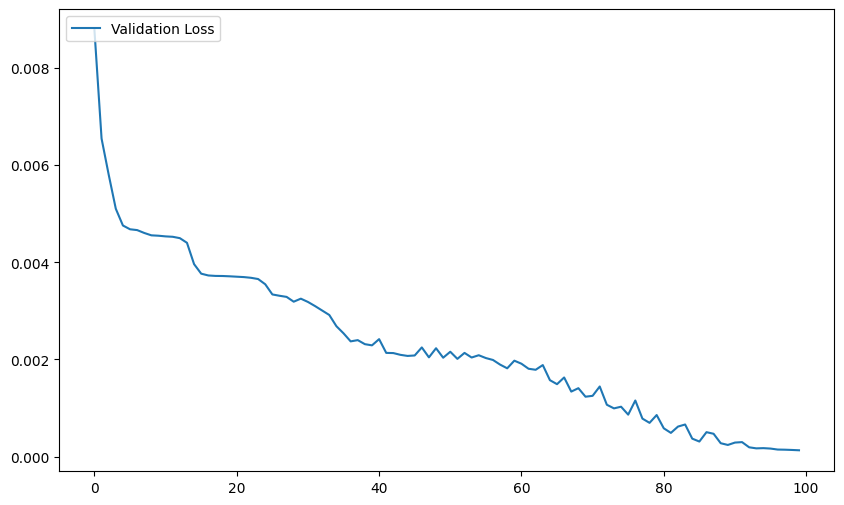

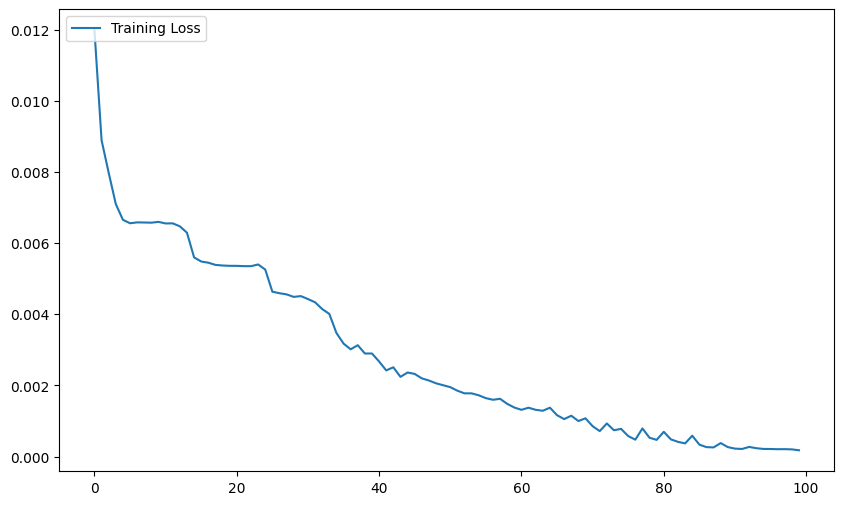

In [14]:
# Show curves validation and training
plt.figure(figsize=(10,6))
plt.plot(valid_loss)
plt.legend(['Validation Loss'], loc='upper left', fontsize=10)

# plot the training loss
plt.figure(figsize=(10,6))
plt.plot(train_loss)
plt.legend(['Training Loss'], loc='upper left', fontsize=10)



# Visualizing the NARMA10 dataset reconstructed by RNN

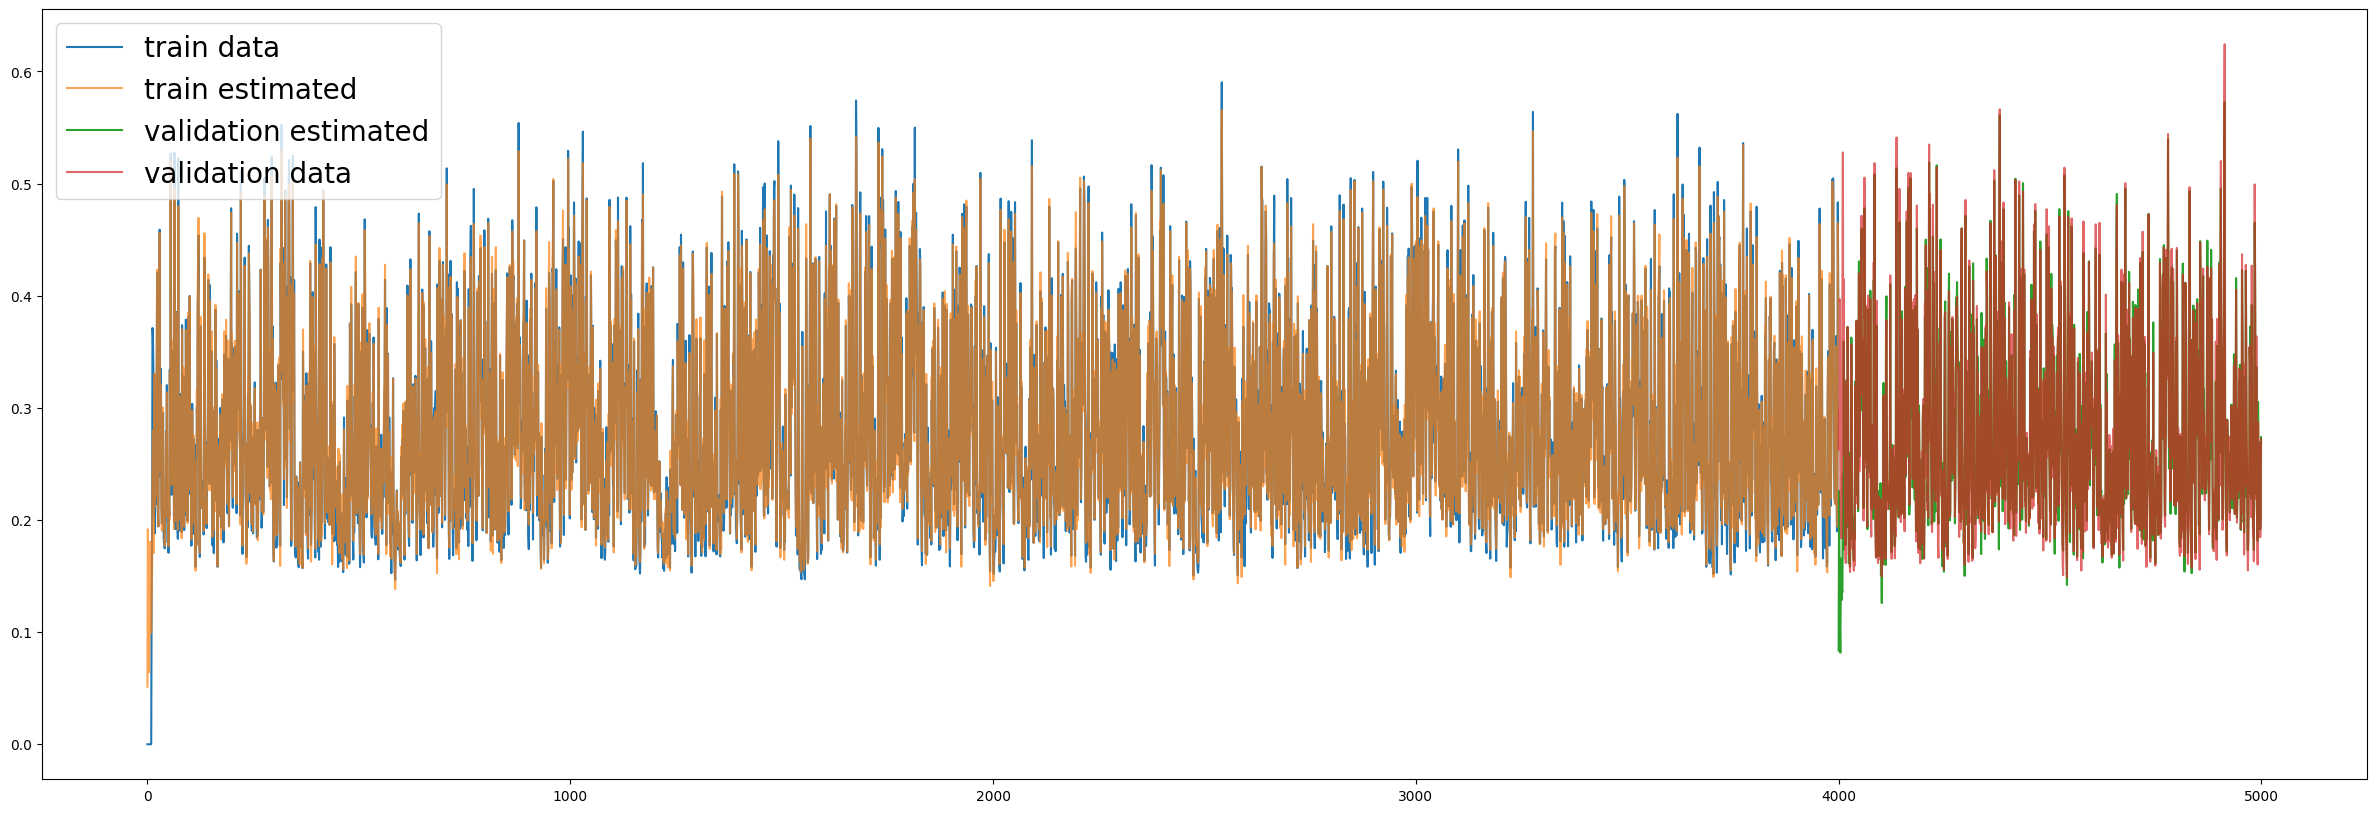

In [15]:
# get prediction for training and validation
train_input_tensor = torch.Tensor(train_input.values).unsqueeze(1).unsqueeze(2)
output_train, _ = rnn(train_input_tensor)

valid_input_tensor = torch.Tensor(valid_input.values).unsqueeze(1).unsqueeze(2)
output_valid, _ = rnn(valid_input_tensor)

# detach the tensor
output_train = output_train.detach().numpy()
output_valid = output_valid.detach().numpy()

# figsize 30,10
plt.figure(figsize=(30,10))
# add ground truth for train output
plt.plot(train_output)
# add estimated output for train output
# plot only the first of the tensor
plt.plot(output_train[:,0], alpha=0.7)
# after 4000 step put the output_valid
plt.plot(np.arange(4000, 5000), output_valid[:,0])
# plot output to see if valid is correct
plt.plot(valid_output, alpha=0.7)
plt.legend(['train data', 'train estimated', 'validation estimated', 'validation data'], loc='upper left', fontsize=20)